<a href="https://colab.research.google.com/github/OliciaJg/Klasifikasi-Kebersihan-Tangan-dengan-VGGNet-16/blob/main/Program_Skripsi_Klasifikasi_VGGNet16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import cv2
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Folder data
base_dir = '/content/drive/MyDrive/Data/Train'
# Path ke direktori data asli dan penyimpanan data augmented
data_dir = '/content/drive/MyDrive/Data/Train'
output_dir = '/content/drive/MyDrive/Data/StructuredAugmentedData'
train_dir = '/content/drive/MyDrive/Data/TrainSplit'
val_dir = '/content/drive/MyDrive/Data/ValSplit'




# Buat direktori untuk training dan validation
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Hapus direktori lama untuk memulai dari awal (mencegah duplikasi saat restart session)
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

# Buat direktori baru untuk menyimpan data
os.makedirs(output_dir, exist_ok=True)




Mounted at /content/drive


In [ ]:
# Augmentasi data dengan ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



In [ ]:

# Augmentasi data dan pengaturan untuk training dan validation
for kelas in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, kelas)

    # Buat subdirektori untuk kelas di folder train dan val
    train_class_dir = os.path.join(train_dir, kelas)
    val_class_dir = os.path.join(val_dir, kelas)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    for idx, filename in enumerate(os.listdir(class_dir)):
        file_path = os.path.join(class_dir, filename)

        # Membaca gambar
        img = cv2.imread(file_path)
        img_expanded = np.expand_dims(img, 0)

        # Buat salinan untuk digunakan pada training dan validation
        # Simpan data asli ke train dan val masing-masing sekali
        shutil.copy(file_path, os.path.join(train_class_dir, filename))  # Salinan untuk training
        shutil.copy(file_path, os.path.join(val_class_dir, filename))  # Salinan untuk validation

        # Augmentasi gambar menjadi 9 variasi untuk train dan 1 variasi untuk val
        aug_iter = datagen.flow(img_expanded, batch_size=1)

        # Simpan 8 augmentasi untuk training
        for aug_idx in range(8):
            aug_img = next(aug_iter)[0].astype(np.uint8)
            aug_filename = f"{kelas}_{idx}_train_aug{aug_idx + 1}.jpg"
            cv2.imwrite(os.path.join(train_class_dir, aug_filename), aug_img)

        # Simpan 1 augmentasi untuk validation
        aug_img_val = next(aug_iter)[0].astype(np.uint8)
        aug_filename_val = f"{kelas}_{idx}_val_aug1.jpg"
        cv2.imwrite(os.path.join(val_class_dir, aug_filename_val), aug_img_val)

print("Struktur data untuk training dan validation selesai.")

Struktur data untuk training dan validation selesai.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time

# 1. Arsitektur Model
input_layer = Input(shape=(224, 224, 3))
vgg_base = VGG16(include_top=False, input_tensor=input_layer)
x = Flatten()(vgg_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(3, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=output_layer)

# 2. Kompilasi Model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Data generator untuk melatih model
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/TrainSplit',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/ValSplit',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

# Menghitung class weights berdasarkan distribusi kelas
class_labels = train_generator.classes  # Mendapatkan label kelas dari generator
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights))  # Mengubahnya menjadi dictionary

print("Class Weights:", class_weights)

# Callbacks untuk EarlyStopping dan ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_loss',      # Memonitor loss pada data validasi
    patience=10,             # Jumlah epoch tanpa peningkatan sebelum berhenti
    restore_best_weights=True # Mengembalikan bobot terbaik
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       # Memonitor loss pada data validasi
    factor=0.5,               # Mengurangi learning rate dengan faktor 0.5
    patience=5,               # Jumlah epoch tanpa peningkatan sebelum mengurangi learning rate
    min_lr=1e-6               # Batas minimum learning rate
)

# Menyimpan waktu mulai pelatihan
start_time = time.time()

# Melatih model dengan class weights
# Melatih model dengan class weights, callbacks, dan menyimpan history untuk grafik
history = model.fit(
    train_generator,
    epochs=30,
    class_weight=class_weights,
    validation_data=validation_generator,
   callbacks=[early_stopping, reduce_lr]  # Menambahkan callbacks
)

# Menghitung durasi pelatihan
end_time = time.time()
training_duration = end_time - start_time
print(f"Durasi pelatihan: {training_duration:.2f} detik")

# Simpan model dalam format SavedModel
model.save('/content/drive/MyDrive/Data/ModelBaru/model_vggnet16_fixed1b.keras')

# Mendapatkan data akurasi dan loss dari history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(train_acc) + 1)

# Plot Akurasi
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 405 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Class Weights: {0: 1.0, 1: 1.0, 2: 1.0}
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 994s 37s/step - accuracy: 0.3012 - loss: 1.2642 - val_accuracy: 0.3333 - val_loss: 1.1013 - learning_rate: 1.0000e-04
Epoch 2/30
20/26 ━━━━━━━━━━━━━━━━━━━━ 3:30 35s/step - accuracy: 0.3295 - loss: 1.1188

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 90 images belonging to 3 classes.
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 1.0000 - loss: 2.6528e-06
Validation Loss: 0.0000
Validation Accuracy: 1.0000
Model yang telah dievaluasi disimpan di /content/drive/MyDrive/Data/ModelBaru/model_vggnet16_evaluated1.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step


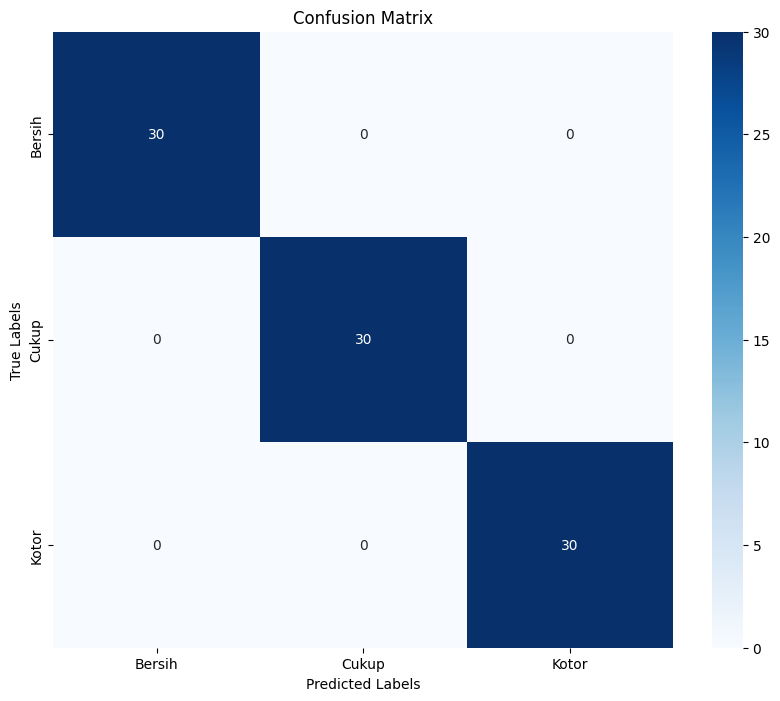

Classification Report:
               precision    recall  f1-score   support

      Bersih       1.00      1.00      1.00        30
       Cukup       1.00      1.00      1.00        30
       Kotor       1.00      1.00      1.00        30

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Direktori data validasi baru
new_validation_dir = '/content/drive/MyDrive/Data/ValSplit'

# ImageDataGenerator untuk data validasi baru
new_validation_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data validasi baru
new_validation_generator = new_validation_datagen.flow_from_directory(
    new_validation_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Memuat model yang sudah dilatih
model = load_model('/content/drive/MyDrive/Data/ModelBaru/model_vggnet16_fixed1.keras')

# Evaluasi model pada data validasi baru
val_loss, val_accuracy = model.evaluate(new_validation_generator)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Simpan model setelah evaluasi
evaluated_model_path = '/content/drive/MyDrive/Data/ModelBaru/model_vggnet16_evaluated1.keras'
model.save(evaluated_model_path)
print(f"Model yang telah dievaluasi disimpan di {evaluated_model_path}")

# Menghasilkan prediksi
val_predictions = model.predict(new_validation_generator)
val_pred_classes = np.argmax(val_predictions, axis=1)

# Label sebenarnya
true_classes = new_validation_generator.classes

# Nama kelas
class_labels = list(new_validation_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(true_classes, val_pred_classes, target_names=class_labels)
print("Classification Report:\n", report)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import load_model
import os
import shutil

# Path model dan folder test
model_path = '/content/drive/MyDrive/Data/ModelBaru/model_vggnet16_evaluated1.keras'
test_dir = '/content/drive/MyDrive/Data/Test'
augmented_test_dir = '/content/drive/MyDrive/Data/Augmented_Test'

# Memuat model yang sudah dilatih
model = load_model(model_path)

# Mendefinisikan kelas
class_names = sorted(os.listdir('/content/drive/MyDrive/Data/TrainSplit'))

# Membuat folder Augmented_Test jika belum ada
if not os.path.exists(augmented_test_dir):
    os.makedirs(augmented_test_dir)

# Membuat ImageDataGenerator untuk augmentasi
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Meng-augmentasi setiap gambar dalam folder test
for category in os.listdir(test_dir):
    category_path = os.path.join(test_dir, category)
    augmented_category_path = os.path.join(augmented_test_dir, category)

    if not os.path.exists(augmented_category_path):
        os.makedirs(augmented_category_path)

    for img_file in os.listdir(category_path):
        img_path = os.path.join(category_path, img_file)
        img = load_img(img_path)  # Memuat gambar tanpa mengubah ukuran
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Simpan gambar asli
        shutil.copy(img_path, os.path.join(augmented_category_path, img_file))

        # Menghasilkan satu augmentasi per gambar asli
        aug_iter = datagen.flow(img_array, batch_size=1)
        aug_img = next(aug_iter)[0].astype(np.uint8)
        aug_img_path = os.path.join(augmented_category_path, f"aug_{img_file}")
        tf.keras.preprocessing.image.save_img(aug_img_path, aug_img)




In [ ]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path model dan folder data uji augmentasi
model_path = '/content/drive/MyDrive/Data/ModelBaru/model_vggnet16_evaluated1.keras'  # Ganti dengan path model Anda
augmented_test_dir = '/content/drive/MyDrive/Data/Augmented_Test'  # Ganti dengan path folder augmentasi

# Memuat model yang sudah dilatih
model = load_model(model_path)

# Mendefinisikan kelas berdasarkan folder train (pastikan urutan kelas sama dengan saat training)
class_names = sorted(os.listdir('/content/drive/MyDrive/Data/TrainSplit'))  # Ganti dengan path folder Train Anda

# Fungsi untuk menguji semua gambar di folder augmented test
def predict_all_images_in_folder(folder_path):
    class_confidences = {class_name: [] for class_name in class_names}  # Menyimpan keyakinan per kelas

    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)

        print(f"\nPrediksi untuk kategori: {category}")

        for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)

            # Memuat dan mengubah ukuran gambar hanya untuk prediksi
            img = load_img(img_path, target_size=(224, 224))  # Resize sesuai input model
            img_array = img_to_array(img) / 255.0  # Normalisasi
            img_array = np.expand_dims(img_array, axis=0)

            # Melakukan prediksi
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions[0])  # Index prediksi kelas
            predicted_label = class_names[predicted_class]  # Nama kelas berdasarkan indeks
            confidence = predictions[0][predicted_class] * 100  # Keyakinan prediksi

            # Menyimpan keyakinan prediksi untuk rata-rata nanti
            class_confidences[predicted_label].append(confidence)

            print(f"File: {img_file} - Nama produk yang diprediksi: {predicted_label} dengan keyakinan {confidence:.2f}%")

    # Menghitung dan menampilkan rata-rata keyakinan untuk setiap kelas
    print("\nRata-rata keyakinan untuk setiap kelas:")
    for class_name, confidences in class_confidences.items():
        if confidences:
            avg_confidence = np.mean(confidences)
            print(f"Kelas {class_name}: Rata-rata keyakinan {avg_confidence:.2f}%")
        else:
            print(f"Kelas {class_name}: Tidak ada data untuk dihitung.")

# Menguji semua gambar di folder augmented test
predict_all_images_in_folder(augmented_test_dir)



Prediksi untuk kategori: Cukup
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
File: Wahyu Cukup 2.jpg - Nama produk yang diprediksi: Cukup dengan keyakinan 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
File: Hengky Cukup 1.jpg - Nama produk yang diprediksi: Cukup dengan keyakinan 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
File: aug_Isro Cukup 2 (1).jpeg - Nama produk yang diprediksi: Cukup dengan keyakinan 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
File: Isro Cukup 2 (1).jpeg - Nama produk yang diprediksi: Cukup dengan keyakinan 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
File: aug_Wahyu Cukup 2.jpg - Nama produk yang diprediksi: Cukup dengan keyakinan 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
File: Salsa Cukup 1.jpg - Nama produk yang diprediksi: Cukup dengan keyakinan 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
File: aug_Hengky Cukup 1.jpg - Nama produk yang diprediksi: Cukup dengan keyakinan 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
File: Hesti cukup 2.jpg - Nama produk yang dipr

In [ ]:
import tensorflow as tf

# Path ke model .keras
model_path = "/content/drive/MyDrive/Data/ModelBaru/model_vggnet16_evaluated1.keras"

# Memuat model .keras
model = tf.keras.models.load_model(model_path)

# Mengonversi model menjadi format .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model .tflite
tflite_model_path = "/content/drive/MyDrive/Data/ModelBaru.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"Model berhasil dikonversi dan disimpan di: {tflite_model_path}")


Saved artifact at '/tmp/tmpes23il4g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139446414375424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139446317846016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139446317850064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139446317854992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139446317851472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139446317895696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139446317893232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139446317894640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139446317897280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139446317898512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1394463179006